In [5]:
import sys
sys.path.append("C:\\Users\\olgat\\Desktop\\Stage Amiens\\6_Github\\1_FUNCTIONS") 
import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import mean_squared_error

In [6]:
def list_to_array(input_list):
    np_list=[]
    for elem in input_list:
        df = pd.read_csv(elem, header=None).fillna(0)
        df = df.iloc[:,[38, 40, 41,	42,	88,	89,	90,	91,	92,	83,	84,	85,	86,	87,	74,	75,	76,	77,	78,	79,	80,	81,	82,	72,	73,	67, # LEFT
                         98,	45,	44,	43,	46,	47,	48,	49,	50,	51,	52,	53,	54,	55,	56,	57,	58,	59,	60,	61,	62,	63,	64,	68,	69,	65]]

        np_array = df.to_numpy()
        np_list.append(np.nan_to_num(np_array))
    return np_list

In [7]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps # trouver la fin de sequense
        if end_ix > len(sequences)-1: # vérifier si on est au-delà du dataset
            break            
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :] # rassembler les parties d'entrée et de sortie
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
def create_time_steps(length):
    return list(range(-length, 0))
def multi_step_plot(true_future, prediction, num_marker, num_marker_2 = None):
    plt.figure(figsize=(15, 10))
    num_out = len(true_future)
    plt.subplot(2, 2, 1)
    plt.plot(np.arange(num_out), np.array(true_future[:, num_marker:num_marker+1]), 'b-',
           label='Real mvt. Left side')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction[:, num_marker:num_marker+1]), 'r',
                 label='Predicted mvt')
    #plt.ylim(0, 25)
    #plt.ylim(0,1)
    plt.title(f'Marker {num_marker}')
    plt.ylabel('Displacement')
    plt.xlabel('Time [sec]')        
    plt.legend(loc='upper right')
    if num_marker_2 is not None:
        plt.subplot(2, 2, 2)
        plt.plot(np.arange(num_out), np.array(true_future[:, num_marker_2:num_marker_2+1]), 'b-',
               label='Real mvt. Right side')
        if prediction.any():
            plt.plot(np.arange(num_out), np.array(prediction[:, num_marker_2:num_marker_2+1]), 'r',
                     label='Predicted mvt')
    #plt.ylim(0, 1)
    #plt.ylim(0, 25)
    plt.title(f'Marker {num_marker_2}')
    plt.ylabel('Displacement')
    plt.xlabel('Time [sec]')    
    plt.legend(loc='upper right')
    plt.show()

In [11]:
# statistics for two sides of the face
def stat(data):
     df_g = data.iloc[:,[0,	1,	2,	3,	4,	5,	6,	7,	8,	9,	10,	11,	12,	13,	14,	15,	16,	17,	18,	19,	20,	21,	22,	23,	24,	25]] # Left
     df_d = data.iloc[:,[26,	27,	28,	29,	30,	31,	32,	33,	34,	35,	36,	37,	38,	39,	40,	41,	42,	43,	44,	45,	46,	47,	48,	49,	50,	51]] # Right

    df_stat_g = df_g.append([df_g.describe().iloc[[1,2],:]]) # mean rmse                             
    df_stat_d = df_d.append([df_d.describe().iloc[[1,2],:]]) # standard deviation for rmse
    return  df_stat_g, df_stat_d

In [12]:
def make_dataset(list_data, n_steps):
    feature_list =[]
    label_list = []
    for elem in list_data:
        feature, label = split_sequences(elem, n_steps)    
        feature_list.append(feature)
        label_list.append(label)
    feature_list  = np.array(feature_list)
    label_list = np.array(label_list)
    dataset = tf.data.Dataset.from_tensor_slices((feature_list, label_list))
    return dataset

In [13]:
model_2 = load_model('lstm_model_5.h5')
model_2.summary()

OSError: SavedModel file does not exist at: lstm_model_7.h5\{saved_model.pbtxt|saved_model.pb}

### Test saine

In [8]:
path = "C:/Users/olgat/Desktop/Stage Amiens/4 - ML_MoCap/Mvt5/5MhrdP0_cup_M5"
dP0_csv = functions.list_of_files(path)
dP0_csv  = dP0_csv[int(len(dP0_csv)*0.7):] 

In [9]:
dP0_list = list_to_array(dP0_csv)
dP0_list = list_to_array(dP0_csv)
inter_list = functions.list_to_interpolate(dP0_list)
scaled_list, max_value_list, min_value_list = functions.scaled_data2(inter_list)

In [10]:
n_steps = 10
list_test = scaled_list
dataset_test = make_dataset(list_data = list_test, n_steps = n_steps)

In [11]:
score = model_2.evaluate(dataset_test, verbose=1)
print("%s: %.2f%%" % (model_2.metrics_names[1], score[1]*100))

11/11 [==============================] - 1s 9ms/step - loss: 0.0045 - root_mean_squared_error: 0.0670
root_mean_squared_error: 6.70%


#### Test 0/1

In [12]:
def rmse(list_test, dataset_test, model):
    row = len(list_test)
    colum = list_test[0].shape[1]
    rmse_test = list()
    for x, y in dataset_test:
        rmse_m = np.zeros((1,colum))
        for i in range(y.numpy().shape[1]):
            rmse = round(mean_squared_error(y.numpy()[:,i], model.predict(x)[:,i], squared=False),5)
            rmse_m[:,i] = rmse
        rmse_test.append(rmse_m)
    newDF_01 = pd.DataFrame(np.zeros((row,colum)))
    for i in range(len(rmse_test)):
        newDF_01.iloc[i] = rmse_test[i]
    return newDF_01

In [13]:
newDF_01 = rmse(list_test, dataset_test, model_2)

In [14]:
df_stat_g, df_stat_d = stat(newDF_01)
mean_g= df_stat_g.iloc[-2].mean()
mean_d = df_stat_d.iloc[-2].mean()
dif_rel = abs(mean_g-mean_d)
mean_g ,mean_d,dif_rel

(0.05654433566433567, 0.05840734265734265, 0.0018630069930069756)

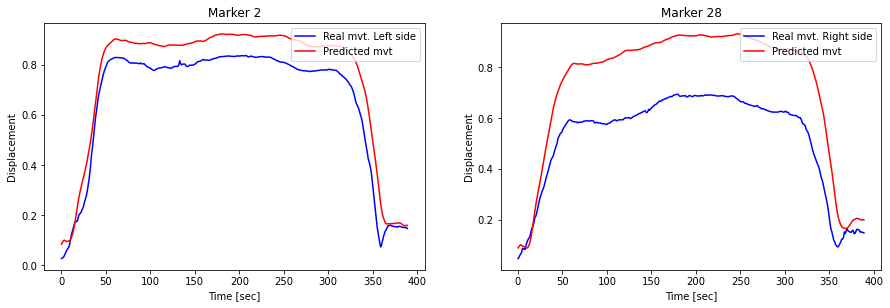

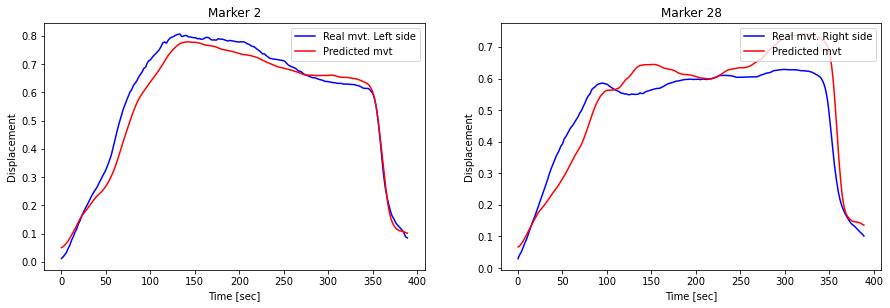

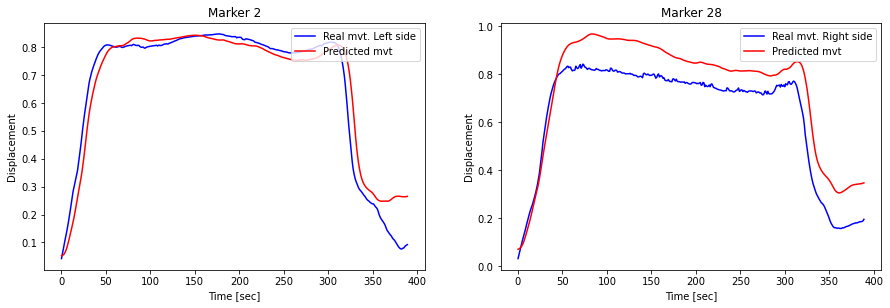

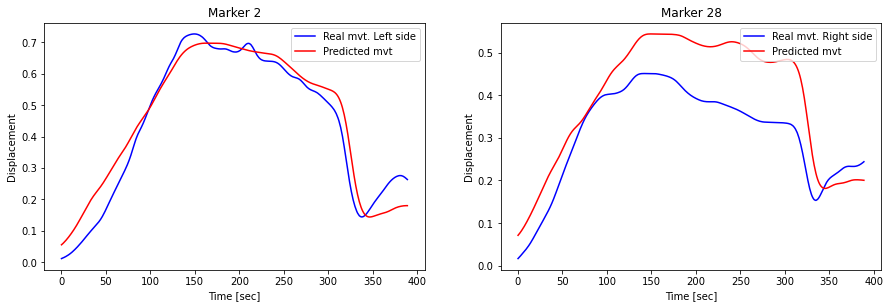

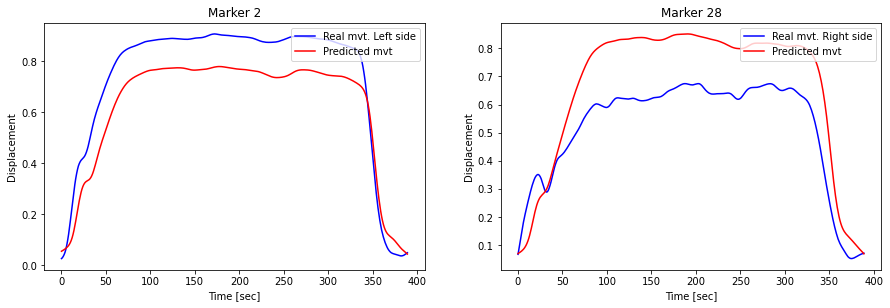

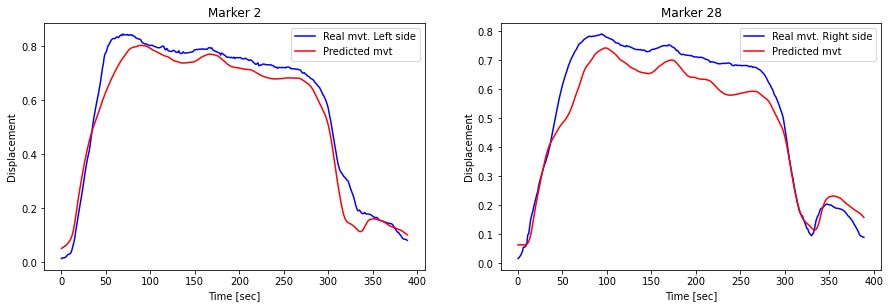

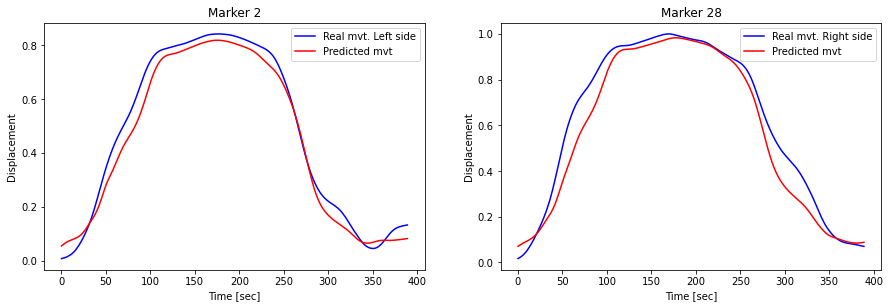

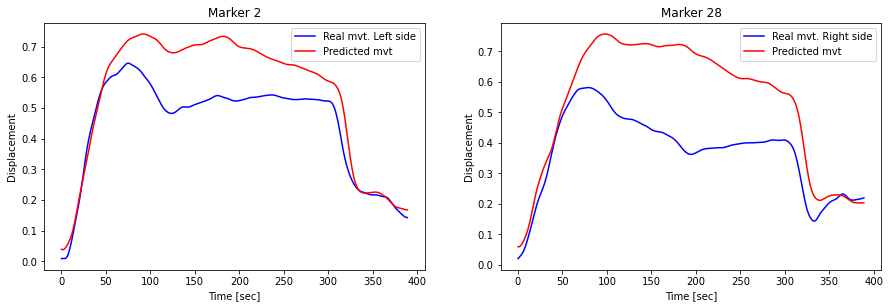

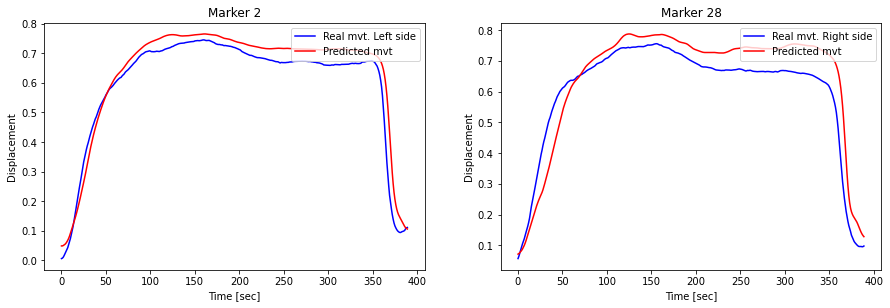

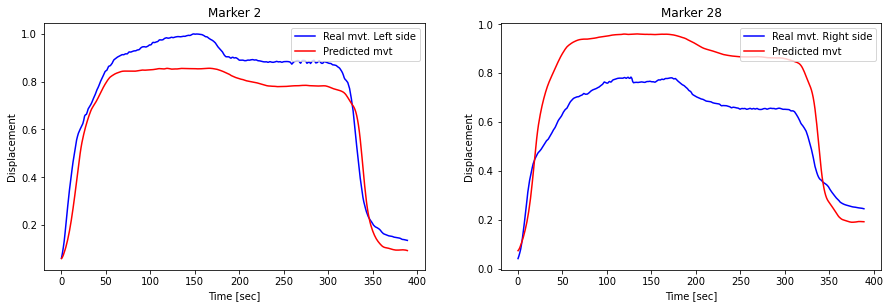

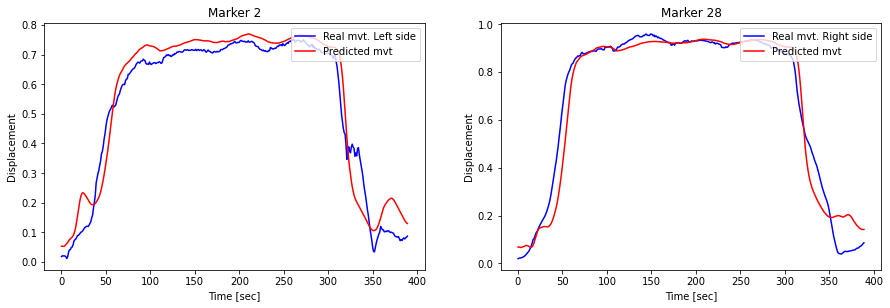

In [15]:
for x, y in dataset_test.take(20):
    multi_step_plot(y,model_2.predict(x), 2,28)

In [16]:
# SAVE
#df_stat_g.to_excel('rmse_s_01_g.xlsx',header=None)
#df_stat_d.to_excel('rmse_s_01_d.xlsx',header=None)

#### Test en mm

In [17]:
def rmse_mm(y_real, yhat):
    row = len(y_real)
    colum = y_real[0].shape[1]
    rmse_test = list()
    newDF = pd.DataFrame(np.zeros((row,colum)))
    for i in range(len(y_real)):
        rmse_m = np.zeros((1,colum))
        for j in range(colum):
            rmse = round(mean_squared_error(y_real[i][:,j], yhat[i][:,j], squared=False),5)
            rmse_m[:,j] = rmse
        rmse_test.append(rmse_m)
    for i in range(len(rmse_test)):
        newDF.iloc[i] = rmse_test[i]    
    return newDF

In [18]:
# initial data dimension (inverse scaled)
y_list, pred_list = list(), list()
for x, Y in dataset_test:   
    y_list.append(Y.numpy())
    pred_list.append(model_2.predict(x))
yhat = functions.list_invers_scaled(pred_list, max_value_list, min_value = 0)
y_real = functions.list_invers_scaled(y_list, max_value_list, min_value = 0)

In [19]:
newDF_mm = rmse_mm(y_real, yhat)
df_stat_g_mm, df_stat_d_mm = stat(newDF_mm)
mean_g= df_stat_g_mm.iloc[-2].mean()
mean_d = df_stat_d_mm.iloc[-2].mean()
dif_rel = abs(mean_g - mean_d)
mean_g, mean_d, dif_rel

(1.0271444055944057, 1.0424175874125876, 0.015273181818181936)

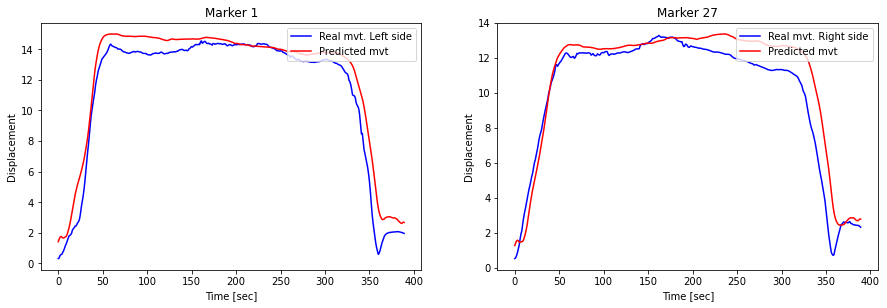

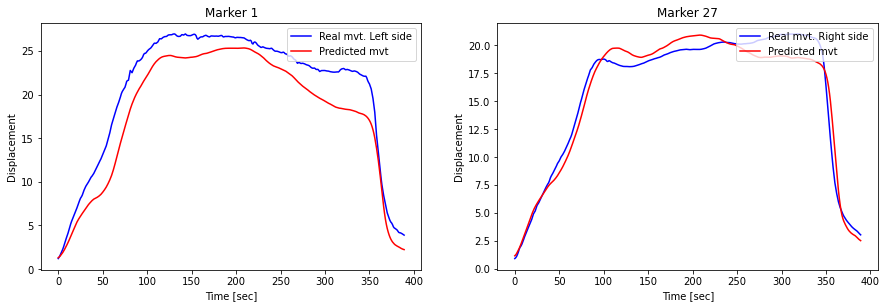

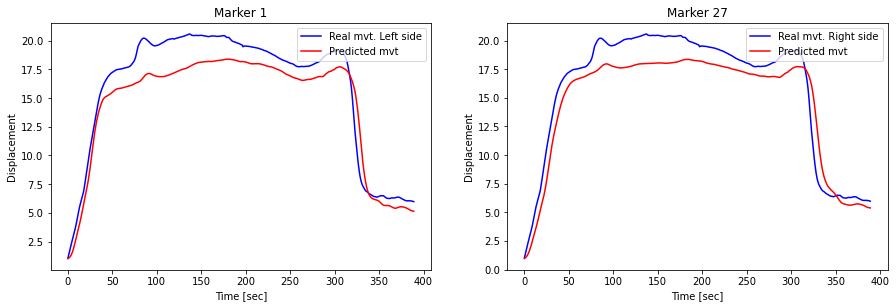

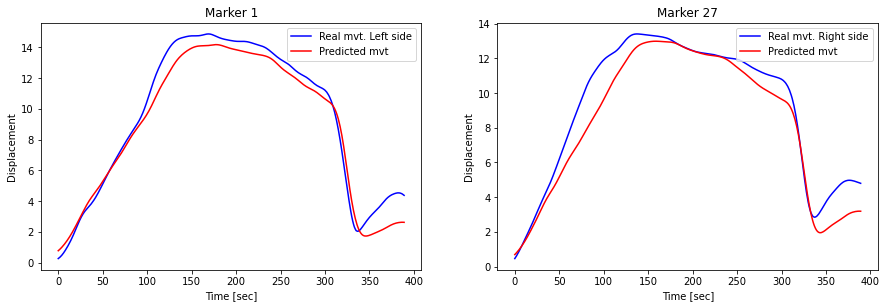

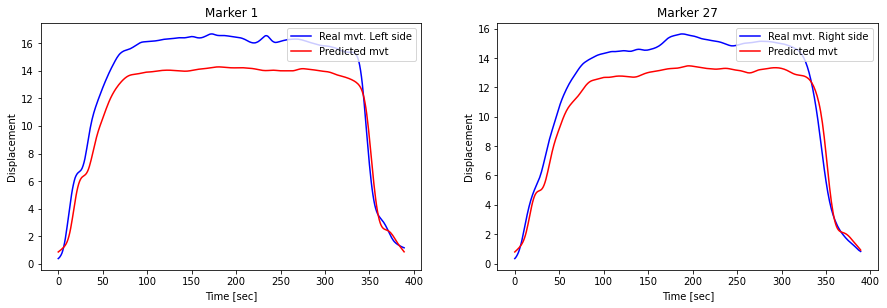

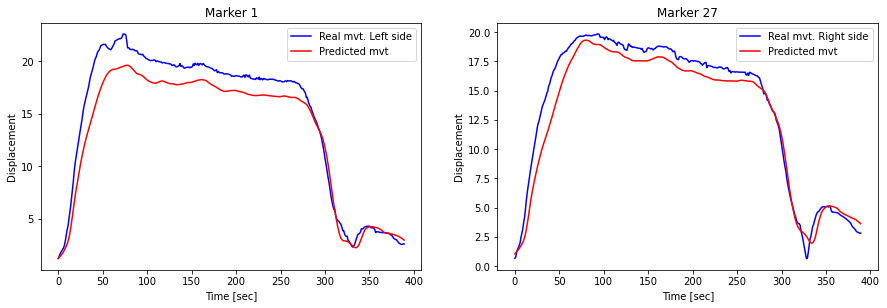

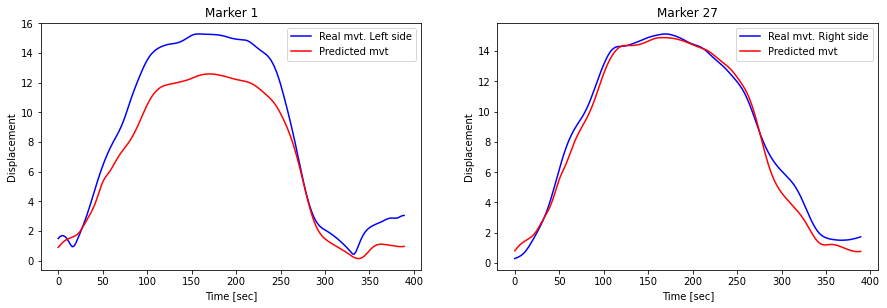

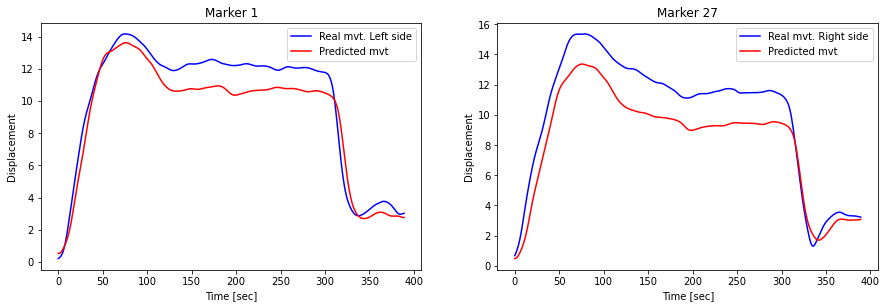

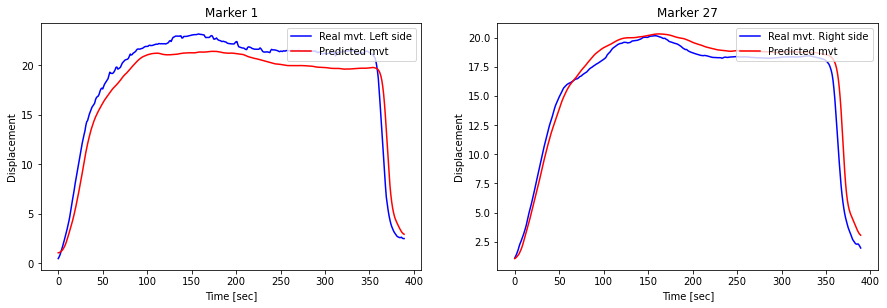

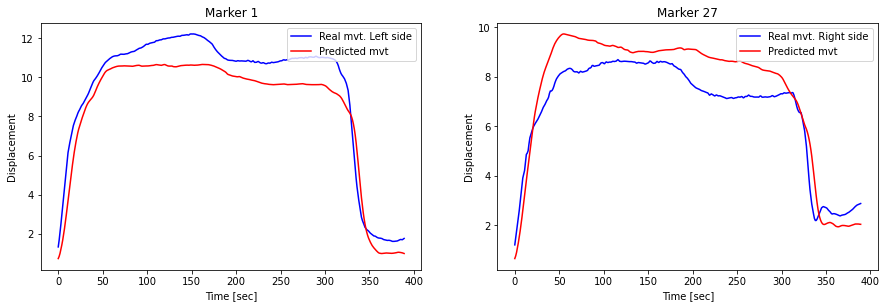

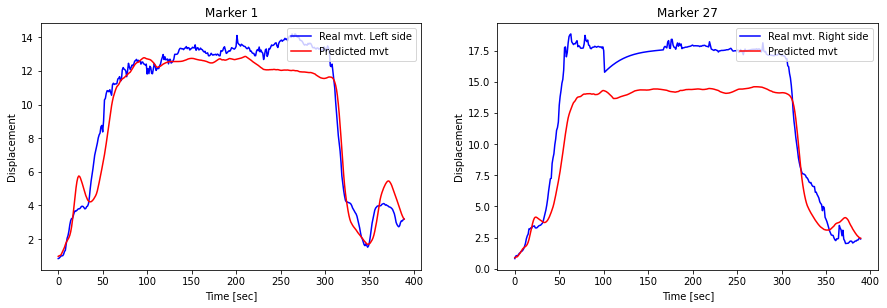

In [20]:
for i in range(len(y_real)):
    multi_step_plot(y_real[i], yhat[i], 1,27) 

In [21]:
# SAVE
#df_stat_g.to_excel('rmse_s_mm_g.xlsx',header=None)
#df_stat_d.to_excel('rmse_s_mm_d.xlsx',header=None)

### Test paralise

In [22]:
path = "C:/Users/olgat/Desktop/Stage Amiens/5 - MALADE/M5prdP0_cup"
dP0p_csv = functions.list_of_files(path, shuffle=False)
#dP0p_csv=dP0p_csv[1:] # patient 1
dP0p_csv=[dP0p_csv[0]] # patient 2
dP0p_csv

['C:\\Users\\olgat\\Desktop\\Stage Amiens\\5 - MALADE\\M5prdP0_cup\\EP01_M5.csv']

In [23]:
# Preposessing
dP0p_list = list_to_array(dP0p_csv)
inter_list_p = functions.list_to_interpolate(dP0p_list)
inter_list_p[0].shape, len(inter_list_p)
scaled_list_p, max_value_list_p, min_value_list_p = functions.scaled_data2(inter_list_p)

In [24]:
list_test_p = scaled_list_p
n_steps = 10
dataset_test_p = make_dataset(list_data = list_test_p, n_steps = n_steps)

In [25]:
score2 = model_2.evaluate(dataset_test_p , verbose=1)
print("%s: %.2f%%" % (model_2.metrics_names[1], score2[1]*100))

1/1 [==============================] - 0s 20ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114
root_mean_squared_error: 11.14%


#### Test 0/1

In [26]:
newDF_01_p = rmse(list_test_p, dataset_test_p, model_2)

In [27]:
df_stat_g_p, df_stat_d_p = stat(newDF_01_p)
mean_g_p= df_stat_g_p.iloc[-2].mean()
mean_d_p = df_stat_d_p.iloc[-2].mean()
dif_rel_p = abs(mean_g_p-mean_d_p)
mean_g_p ,mean_d_p,dif_rel_p

(0.09603, 0.09352884615384616, 0.0025011538461538474)

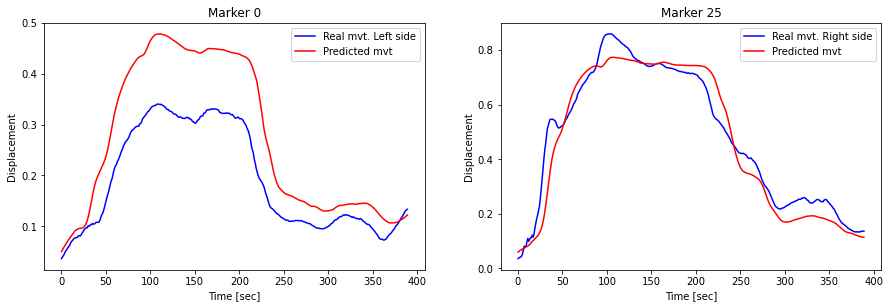

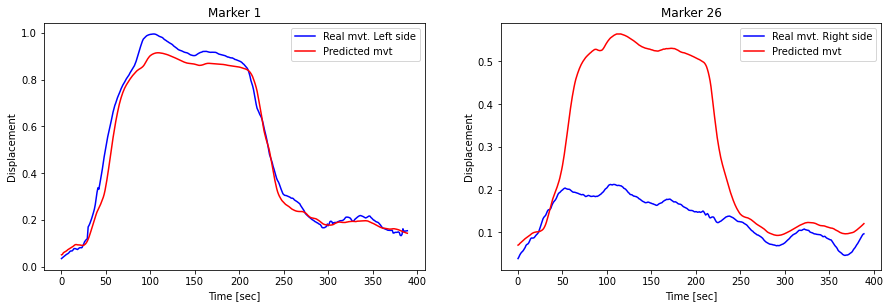

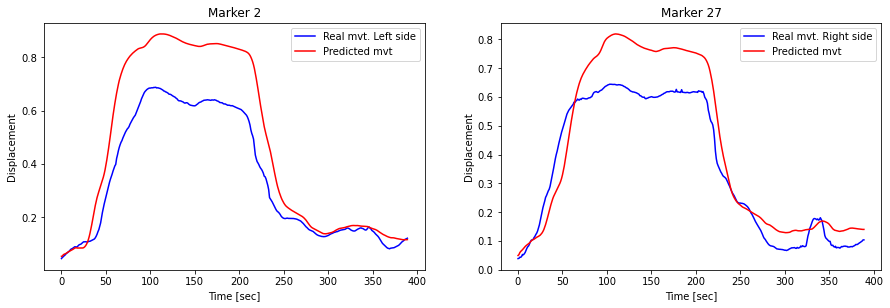

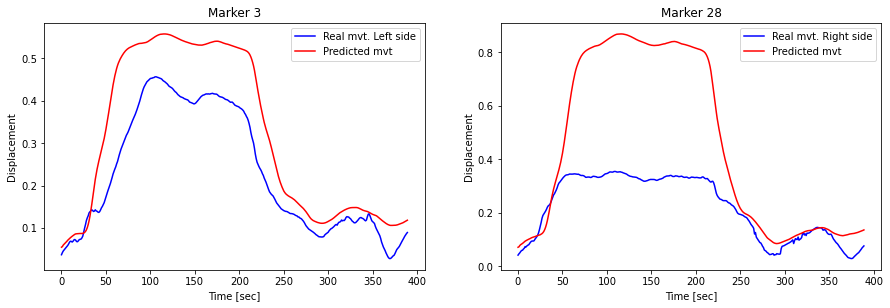

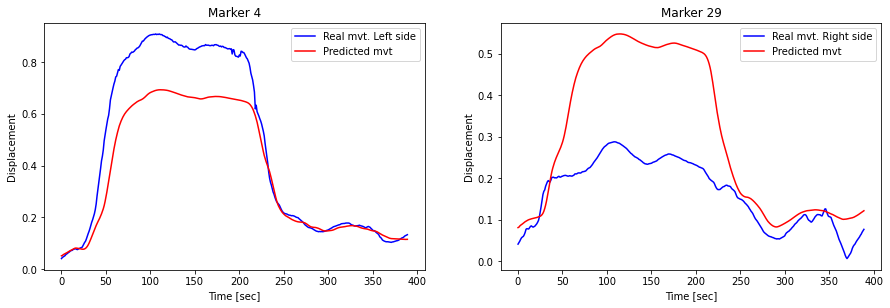

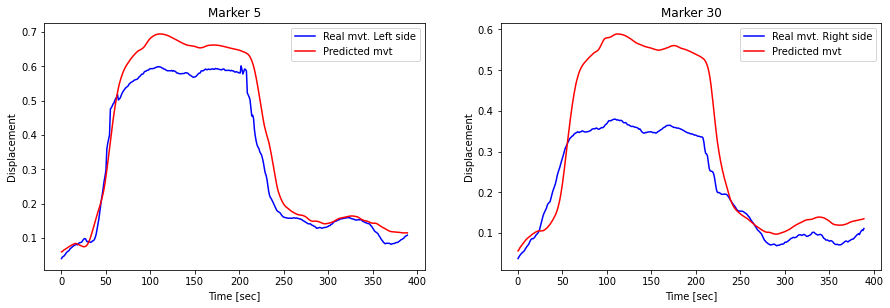

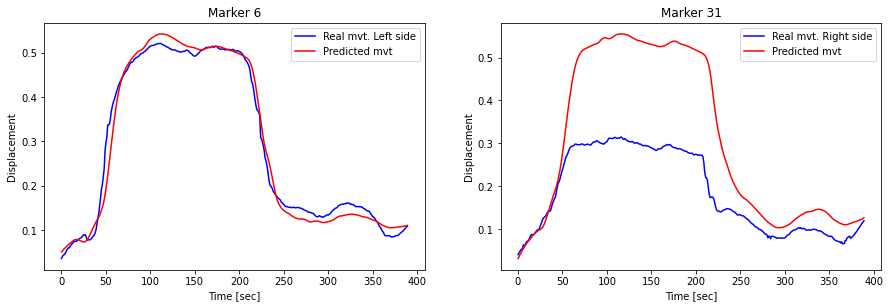

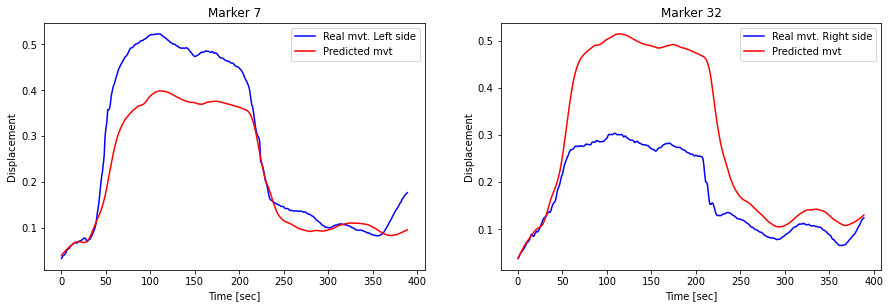

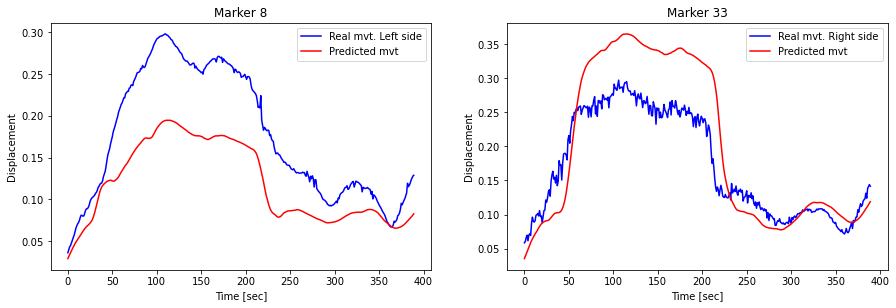

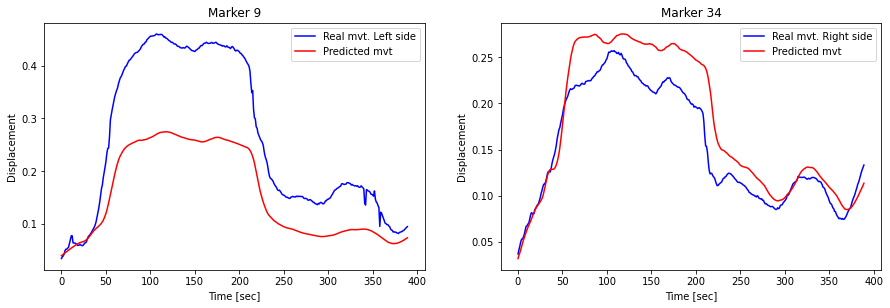

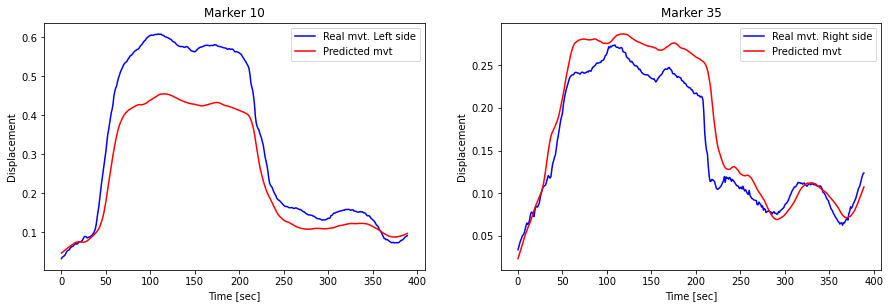

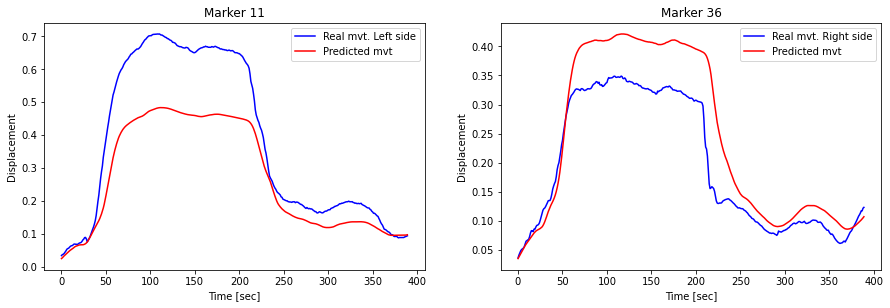

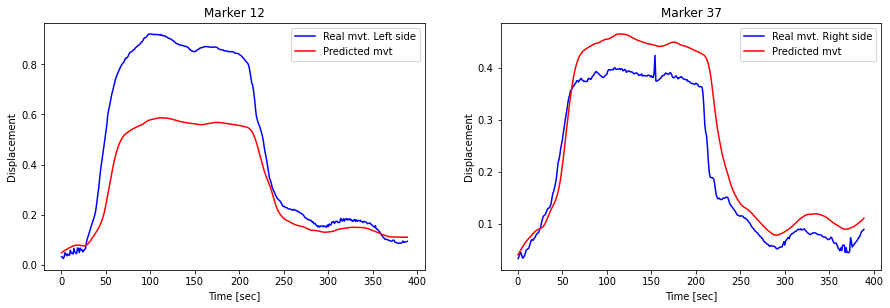

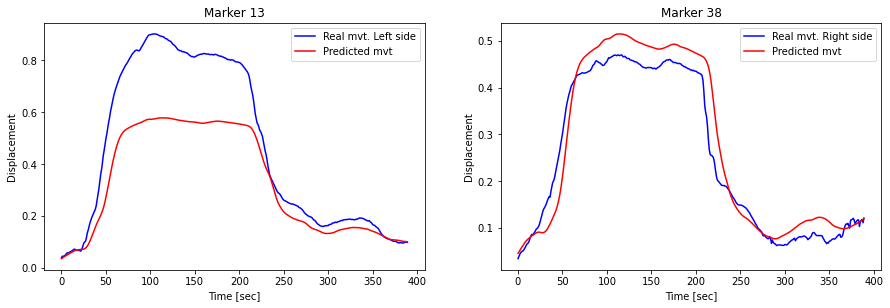

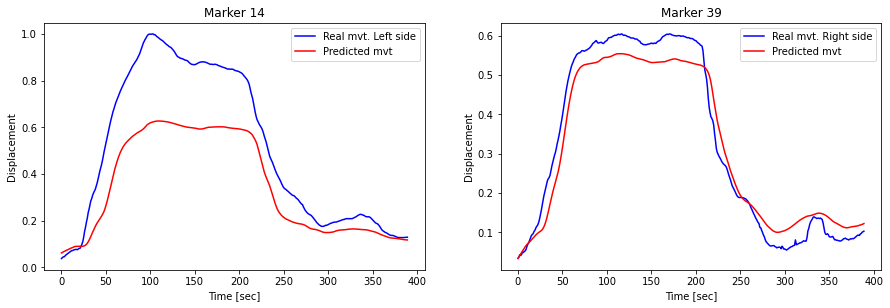

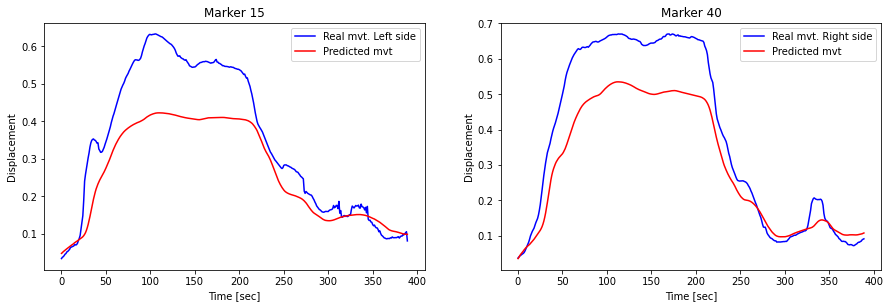

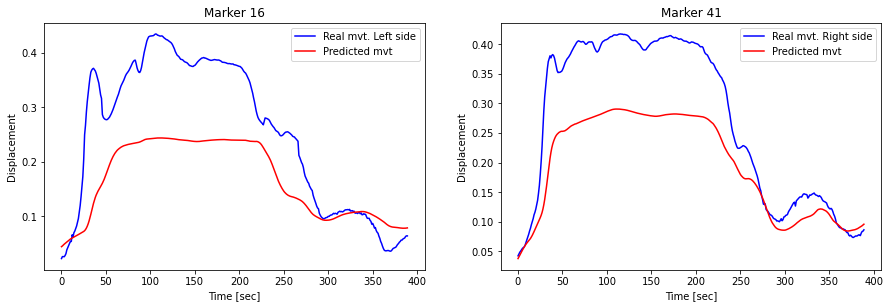

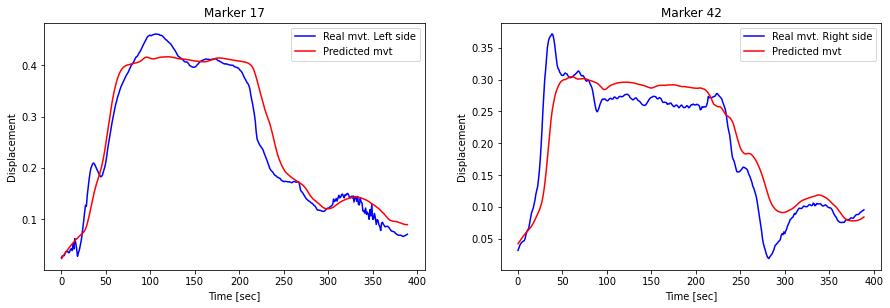

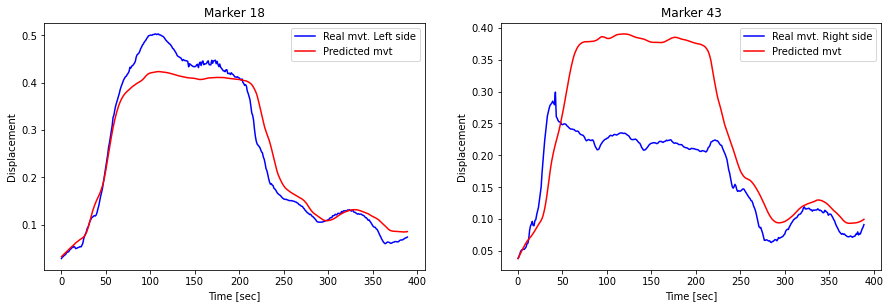

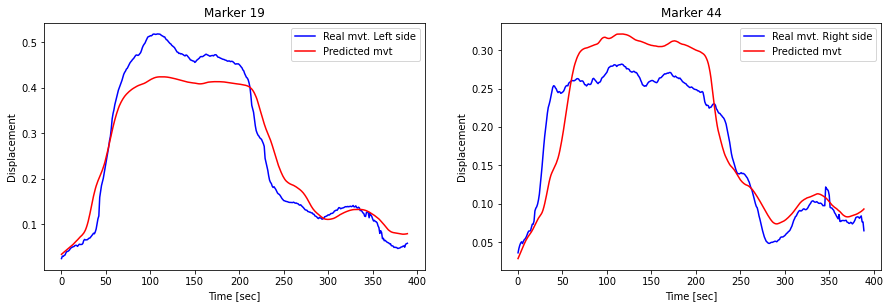

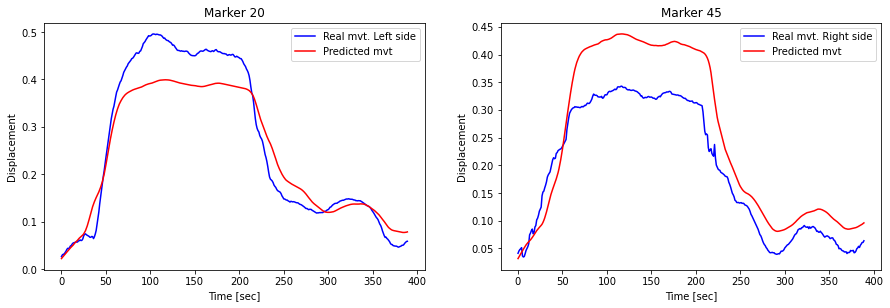

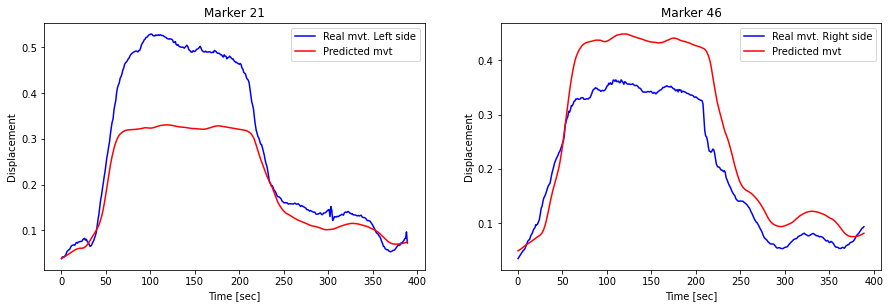

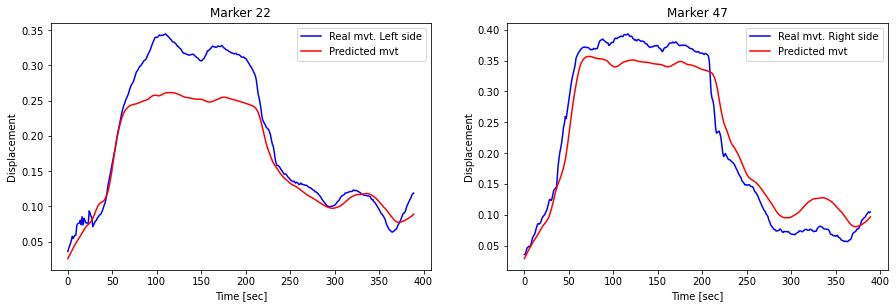

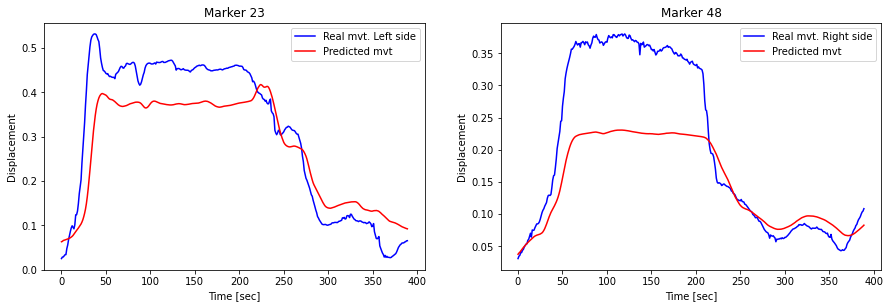

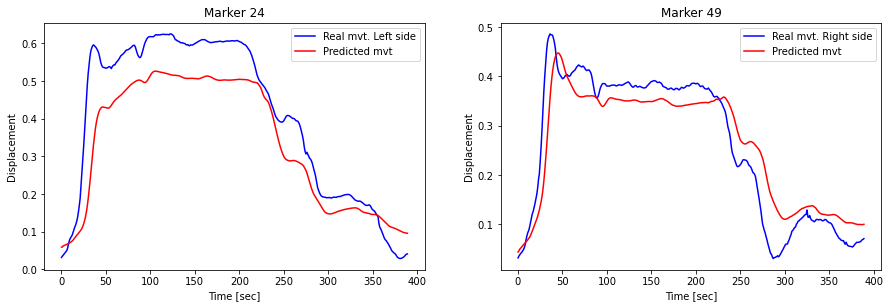

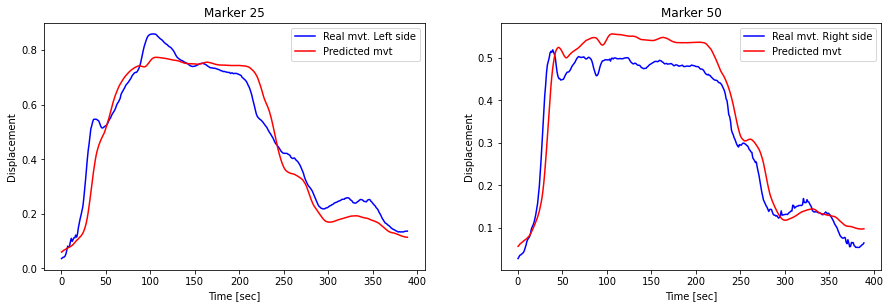

In [28]:
for x, y in dataset_test_p.take(1):
    for i in range(0,26):
        multi_step_plot(y,model_2.predict(x), i,i+25)

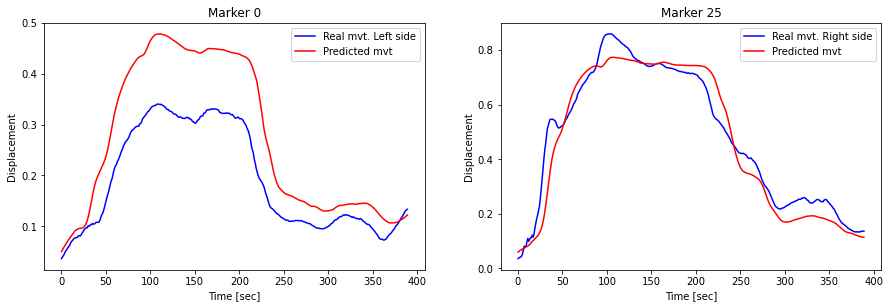

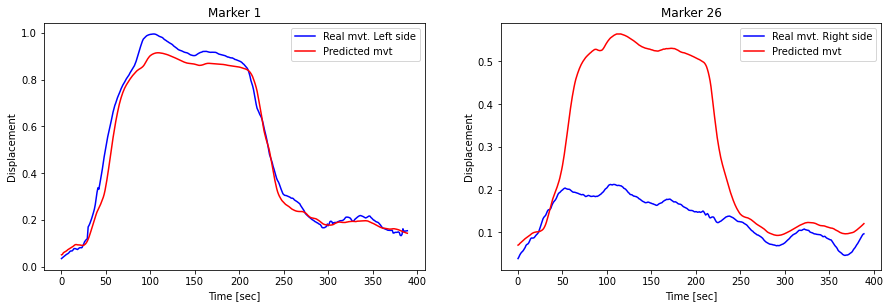

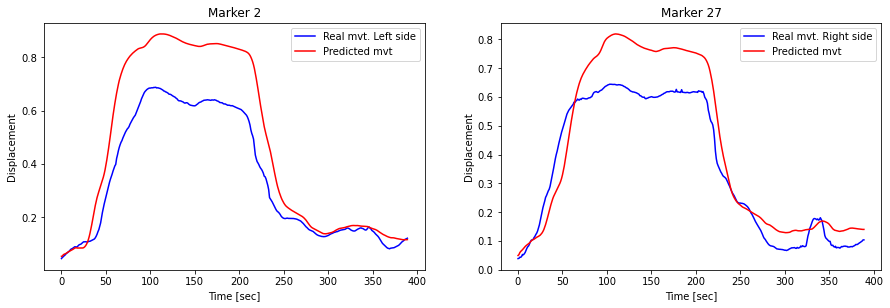

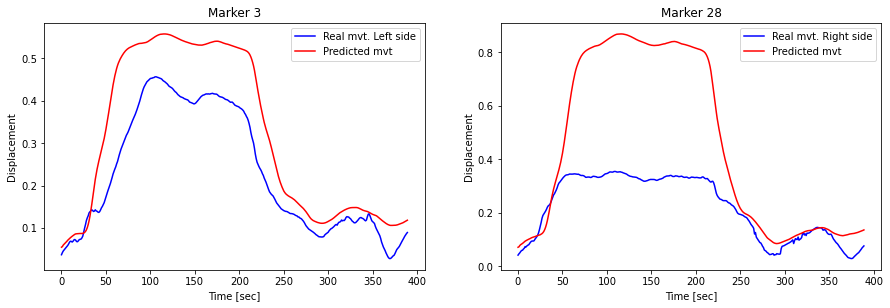

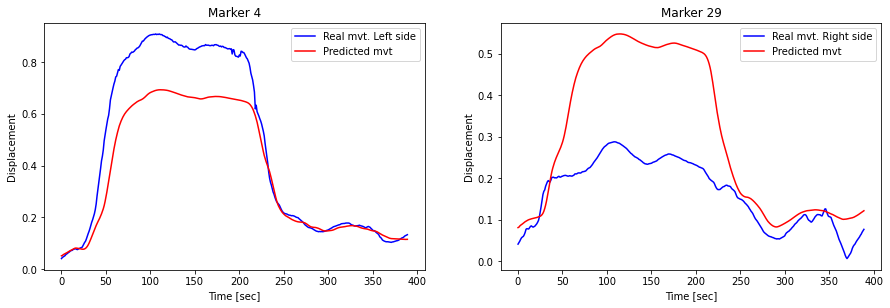

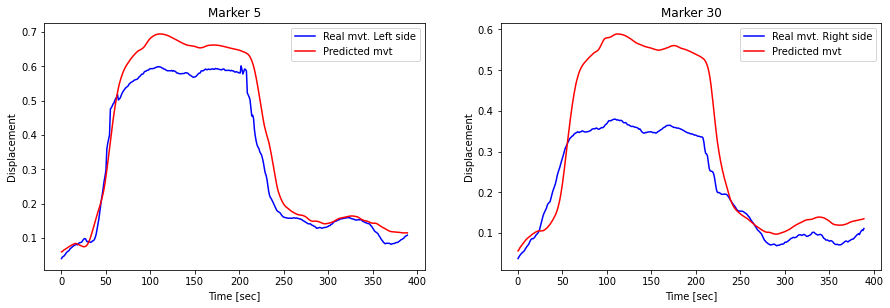

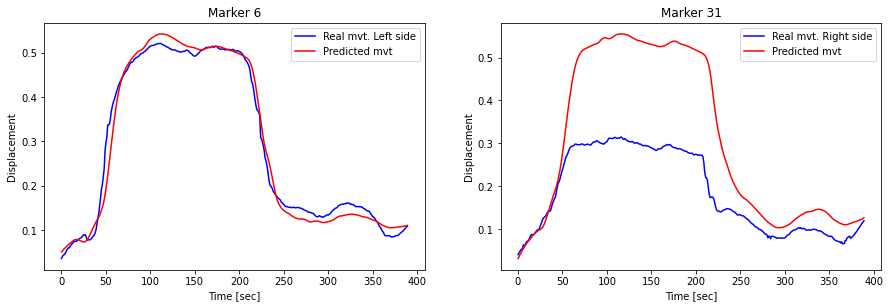

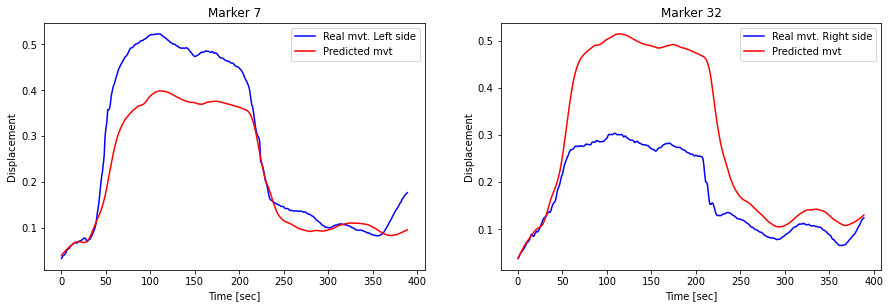

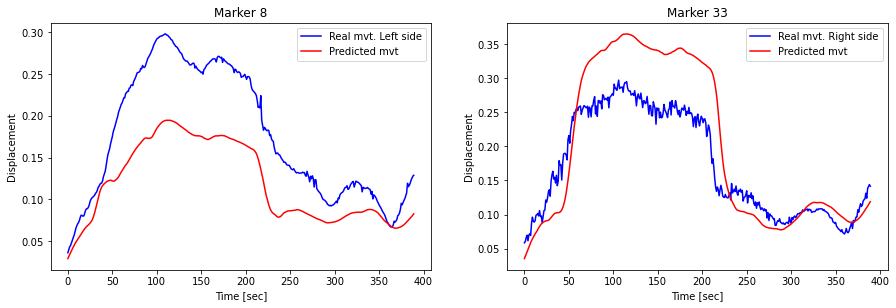

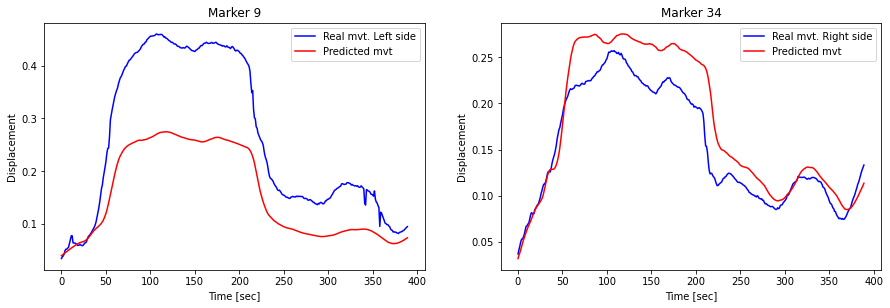

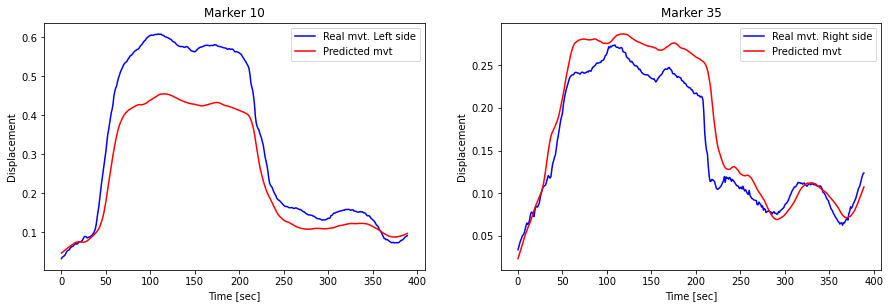

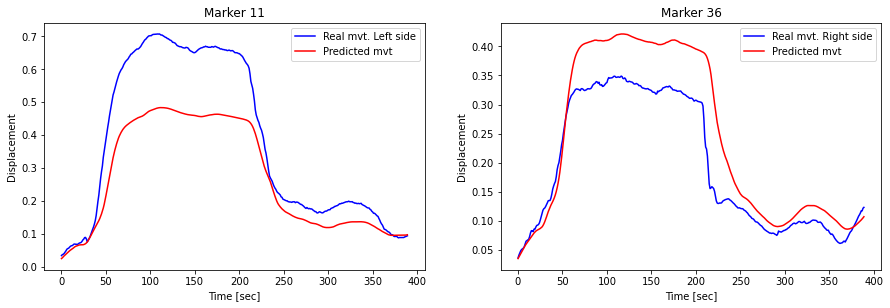

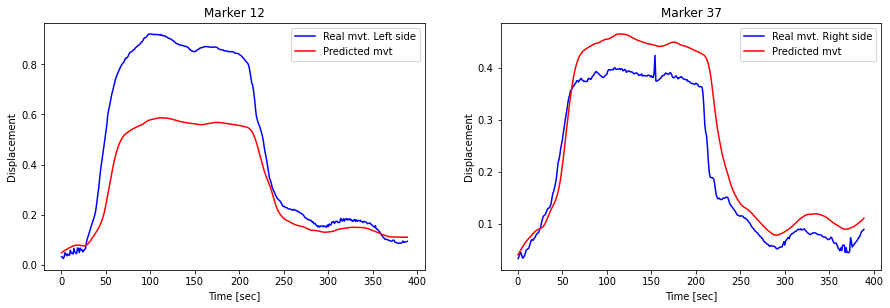

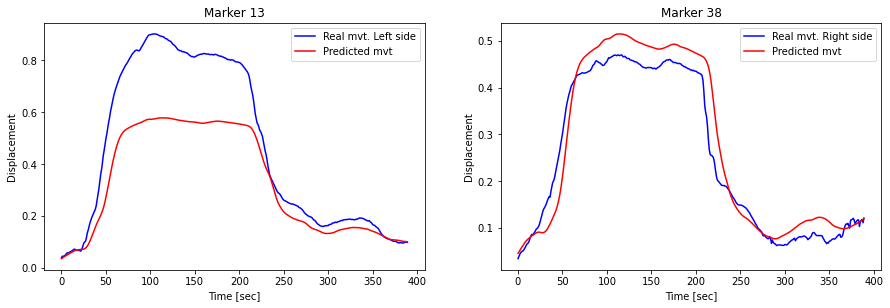

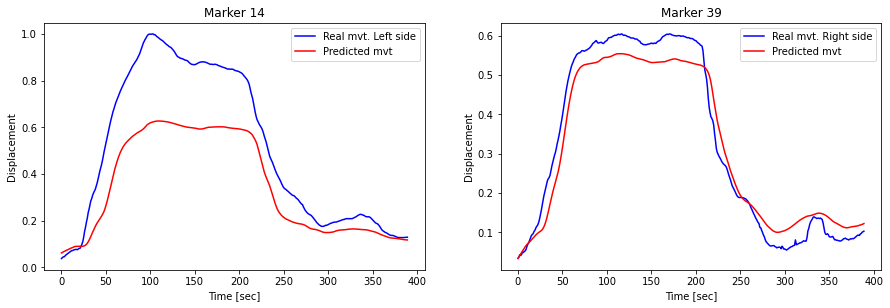

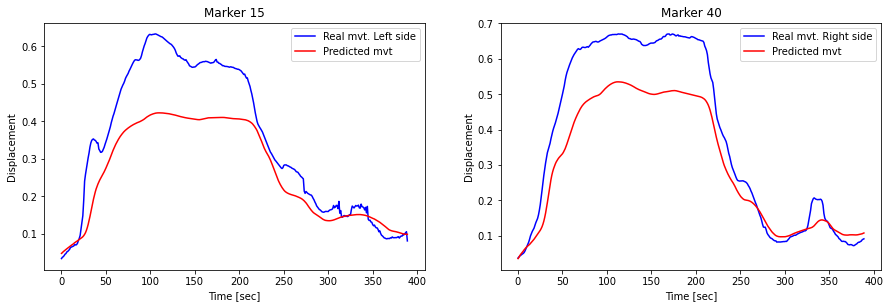

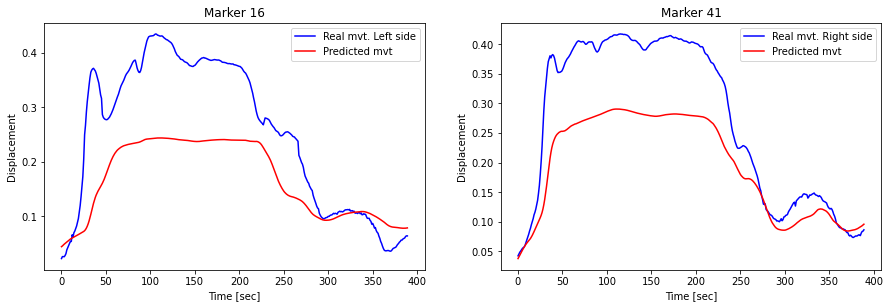

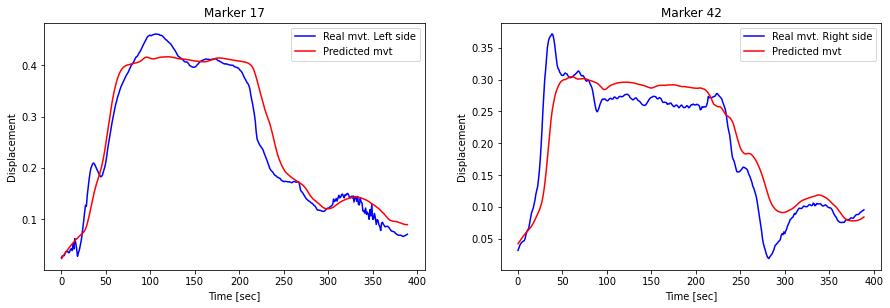

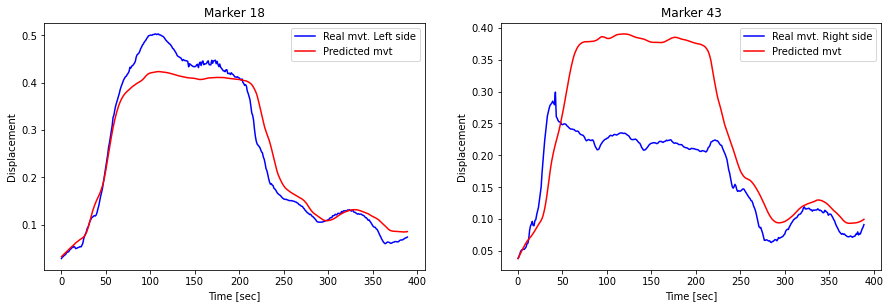

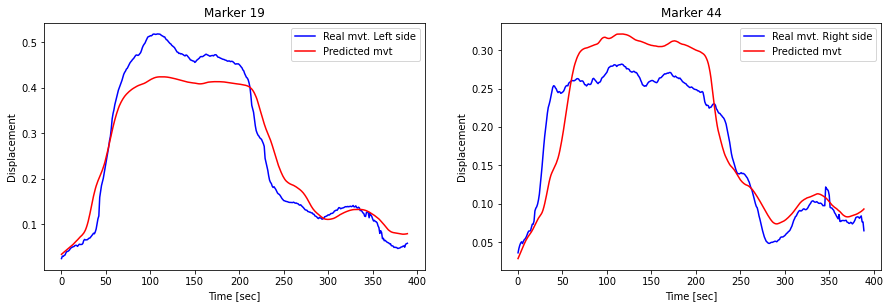

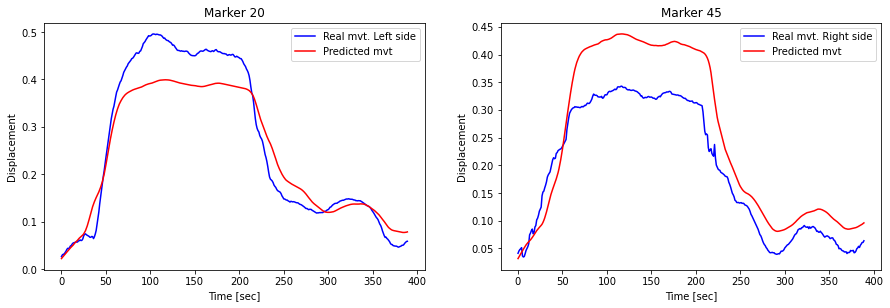

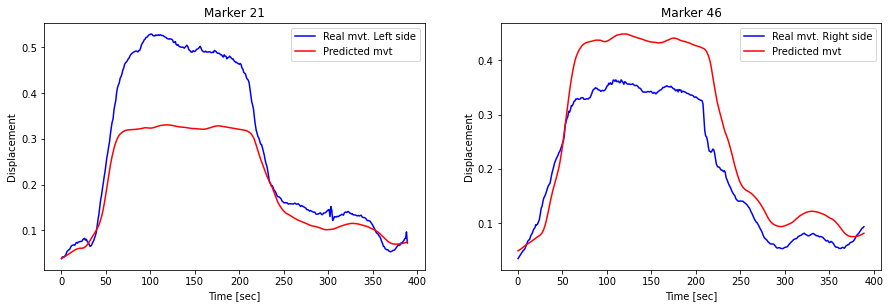

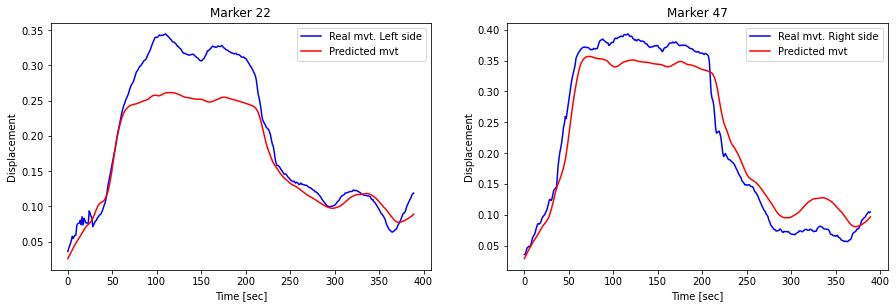

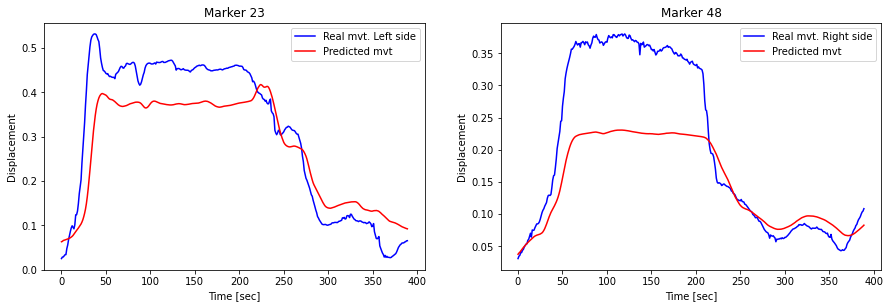

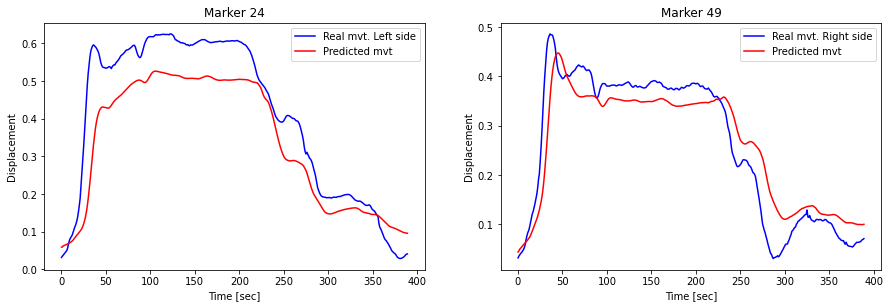

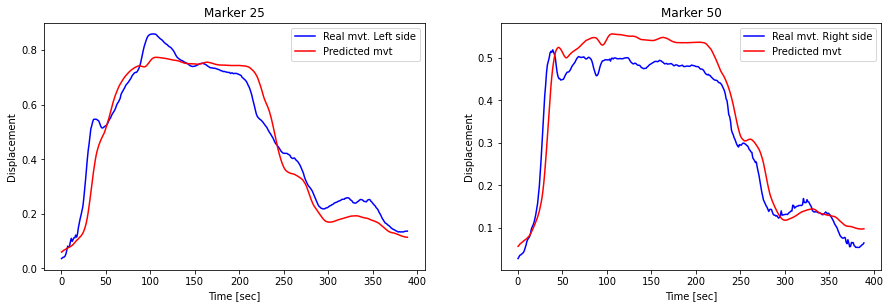

In [29]:
for x, y in dataset_test_p.take(1):
    for i in range(0,26):
        multi_step_plot(y,model_2.predict(x), i,i+25)

In [30]:
# SAVE
#df_stat_g_p.to_excel('rmse_p_01_g.xlsx',header=None)
#df_stat_d_p.to_excel('rmse_p_01_d.xlsx',header=None)

#### Test en mm

In [31]:
## inverse scaled
y_list, pred_list = list(), list()
for x, Y in dataset_test_p:   
    y_list.append(Y.numpy())
    pred_list.append(model_2.predict(x))
yhat_p = functions.list_invers_scaled(pred_list, max_value_list_p, min_value = 0)
y_real_p = functions.list_invers_scaled(y_list, max_value_list_p, min_value = 0)

In [32]:

newDF_mm = rmse_mm(y_real_p, yhat_p)

In [33]:
df_stat_g_mm, df_stat_d_mm = stat(newDF_mm)
mean_g= df_stat_g_mm.iloc[-2].mean()
mean_d = df_stat_d_mm.iloc[-2].mean()
dif_rel = abs(mean_g-mean_d)
mean_g ,mean_d,dif_rel

(1.675347307692308, 1.6317307692307694, 0.04361653846153857)